## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from glob import glob

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.linear_model import LinearRegression

from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [2]:
# List of filenames containing our FOREX data
forex_tables_glob = glob("../data/*.xls")

def create_forex_df(all_files_glob=glob("../data/*.xls")):

    all_files = all_files_glob

    li = []

    for filename in all_files:
        tdf = pd.read_excel(filename, skiprows=5, na_values=['CLOSED', 'closed', 'Closed', ' --']).drop([0,1,2,3,4])
        tdf = tdf.rename(columns={'Units':'Date'})

        # Convert Date to Datetime type
        tdf['Date'] = pd.to_datetime(tdf['Date'])

        # Create time series index
        tdf = tdf.set_index('Date', drop=True)
        li.append(tdf)

    df = pd.concat(li, axis=0, sort=False)
    
    return df

data = create_forex_df(forex_tables_glob).astype('float')

## Train, Validation, Test Split

Train Data : 2017 to 2018\
Validation Data : 2019\
Test Data : Jan 2020 to Feb 2020

In [3]:
# Data after 2017 (past 3 years)
data_3yrs = data['2017':]
df = data_3yrs[['USD']]

print("Total data count = ", df.shape[0])
print("Number of missing values = ", df.isnull().sum().sum())
print()

for i in range(1, 11):
    label = "lag_{}".format(i)
    df[label] = df['USD'].shift(i)
    
df = df.dropna(axis=0)

train_df = df['2017':'2018']
val_df = df['2019']
test_df = df['2020']

print("Count of dates in training data = ", train_df.shape[0])
print("Count of dates in validation data = ", val_df.shape[0])
print("Count of dates in test data = ", test_df.shape[0])

Total data count =  778
Number of missing values =  0

Count of dates in training data =  491
Count of dates in validation data =  251
Count of dates in test data =  26


#### Common Functions

**1. to calculate predictions using Linear Regression**\
**2. to calculate mean absolute percentage error**

In [4]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'USD'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['USD'])):
        X_train = np.array(range(len(df['USD'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['USD'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

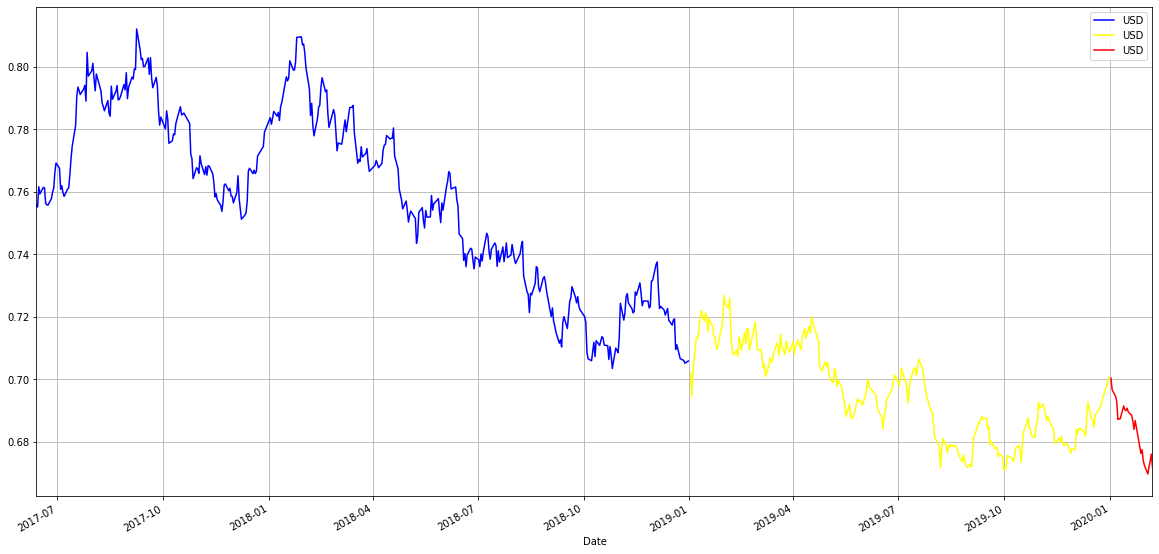

In [5]:
train_rate = train_df[['USD']][100:]
val_rate = val_df[['USD']]
test_rate = test_df[['USD']]

fig, ax = plt.subplots(figsize=(20,10))

train_rate.plot(ax=ax, color='blue', grid=True)
val_rate.plot(ax=ax, color='yellow', grid=True)
test_rate.plot(ax=ax, color='red', grid=True)

## Split into train, dev and test set

In [6]:
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 21                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 462
num_cv = 153
num_test = 153
train.shape = (462, 11)
cv.shape = (153, 11)
train_cv.shape = (615, 11)
test.shape = (153, 11)


## Predict using Linear Regression

In [7]:
import math
Nmax = 30

RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'USD', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['USD'])))
    R2.append(r2_score(cv['USD'], est_list))
    mape.append(get_mape(cv['USD'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [0.0036142510230359392, 0.005190621255650235, 0.00459626083385926, 0.004381551117592768, 0.0044774406934541015, 0.0046542323918761265, 0.004856242982494653, 0.00503363863659641, 0.005252982110978374, 0.005523494915217303, 0.0057076606763137305, 0.005799381661232554, 0.005897894385089429, 0.0060028538582406555, 0.006085303609383657, 0.006171994644534031, 0.006230339082310723, 0.006237473702426545, 0.0062242414817248555, 0.006215619017652199, 0.006204315323162534, 0.006203493580698664, 0.006239705959446406, 0.006297681132943097, 0.006380106776310573, 0.006482733516945069, 0.006598157230173739, 0.006723817681248641, 0.006855065139361349, 0.006992081855759297]
R2 = [0.9007476446372035, 0.7952881993985437, 0.8394857737275683, 0.8541320222482238, 0.8476775625340576, 0.8354111823816694, 0.8208136125887073, 0.8074833634640396, 0.7903397785339642, 0.7681900284485655, 0.7524741908423145, 0.7444548879514056, 0.735699381688987, 0.7262086410209422, 0.7186358904135748, 0.7105621805393431, 0.7

,USD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
Date,,,,,,,,,,,,,,,,,,,,,
2018-11-19,0.7308,0.7269,0.7279,0.7217,0.7212,0.7226,0.7244,0.7274,0.7264,0.7213,...,0.729111,0.728331,0.727580,0.727017,0.726605,0.726091,0.725990,0.725525,0.725283,0.725241
2018-11-20,0.7274,0.7308,0.7269,0.7279,0.7217,0.7212,0.7226,0.7244,0.7274,0.7264,...,0.731128,0.730536,0.729777,0.729039,0.728477,0.728058,0.727539,0.727417,0.726944,0.726685
2018-11-21,0.7235,0.7274,0.7308,0.7269,0.7279,0.7217,0.7212,0.7226,0.7244,0.7274,...,0.732190,0.731665,0.731129,0.730424,0.729731,0.729201,0.728803,0.728306,0.728189,0.727732
2018-11-22,0.7250,0.7235,0.7274,0.7308,0.7269,0.7279,0.7217,0.7212,0.7226,0.7244,...,0.731789,0.731849,0.731416,0.730961,0.730335,0.729712,0.729237,0.728883,0.728430,0.728339
2018-11-23,0.7250,0.7250,0.7235,0.7274,0.7308,0.7269,0.7279,0.7217,0.7212,0.7226,...,0.731877,0.731683,0.731794,0.731429,0.731035,0.730470,0.729900,0.729467,0.729146,0.728726


(2, 30)

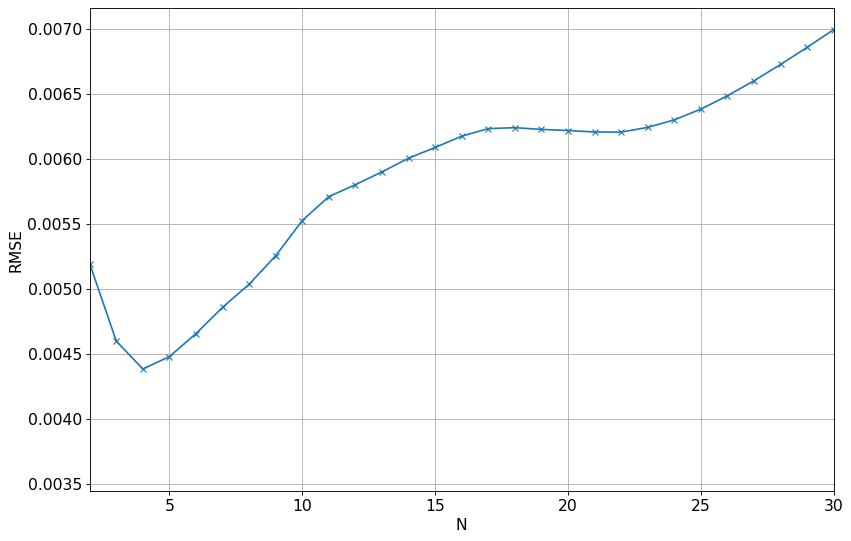

In [8]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

(2, 30)

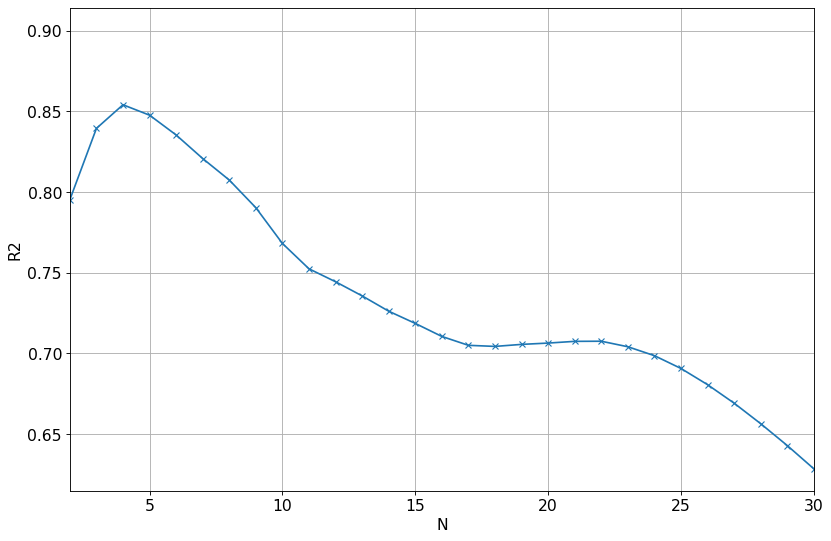

In [9]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')
plt.xlim([2, 30])

(2, 30)

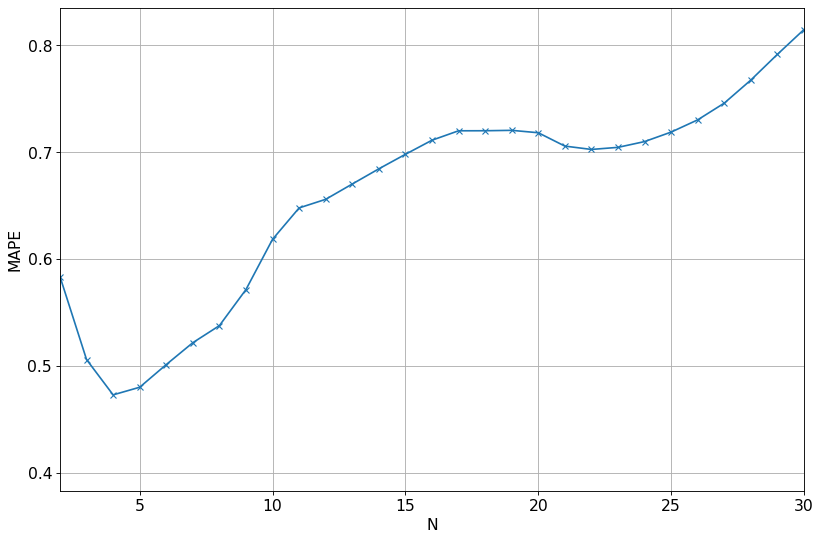

In [10]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')
plt.xlim([2, 30])

In [11]:
# Set optimum N
N_opt = 4

## Plot predictions for a specific day. For checking

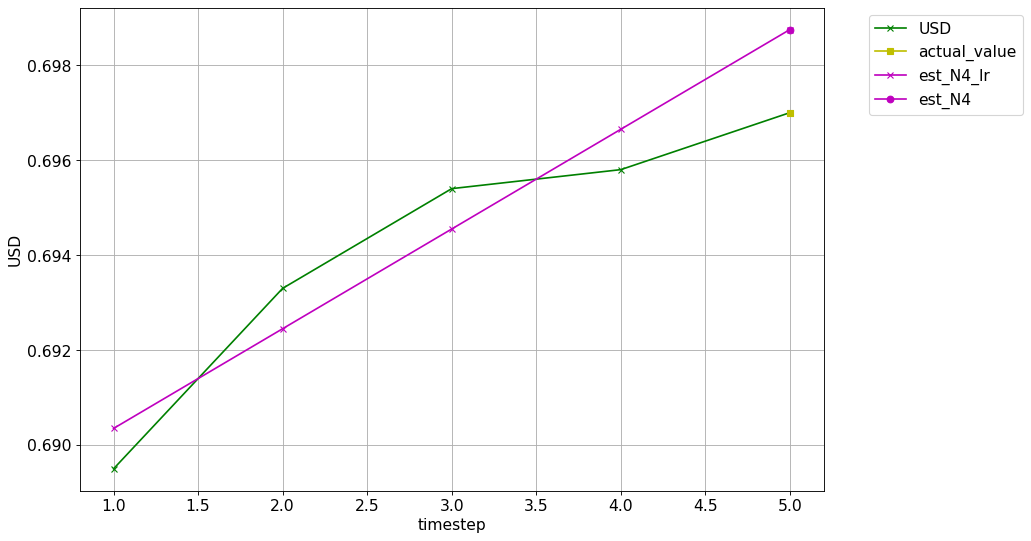

In [12]:
# Plot adjusted close over time
from datetime import date

# Specify the day you are interested in
day = pd.Timestamp(date(2019, 6, 26))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 4

df_temp = cv[cv.index.date <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['USD'], 'gx-')
plt.plot(Nmax2+1, df_temp[-1:]['USD'], 'ys-')
legend_list = ['USD', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(4, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['USD'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['USD'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})


## Plot predictions on dev set

Text(0, 0.5, 'USD')

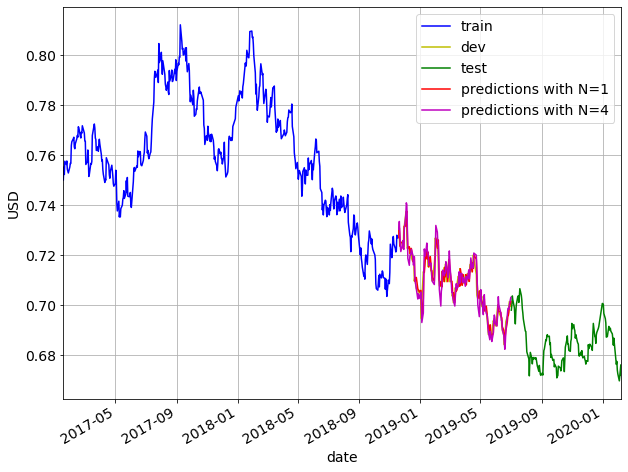

In [13]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(y='USD', style='b-', grid=True)
ax = cv.plot(y='USD', style='y-', grid=True, ax=ax)
ax = test.plot(y='USD', style='g-', grid=True, ax=ax)
ax = cv.plot(y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(y='est_N4', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

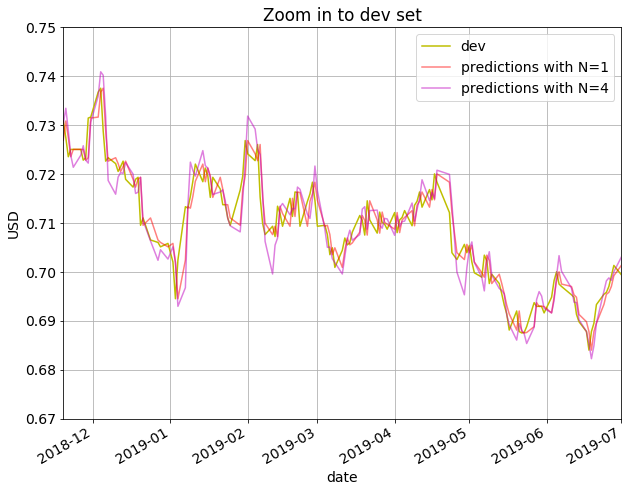

In [14]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = train.plot(y='USD', style='b', grid=True)
ax = cv.plot(y='USD', style='y', grid=True)
# ax = test.plot(y='USD', style='g', grid=True, ax=ax)
ax = cv.plot(y='est_N1', style='r', grid=True, ax=ax, alpha=0.5)
ax = cv.plot(y='est_N4', style='m', grid=True, ax=ax, alpha=0.5)
ax.legend(['dev', 'predictions with N=1', 'predictions with N=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2018, 11, 19), date(2019, 7, 1)])
ax.set_ylim([0.67, 0.75])
ax.set_title('Zoom in to dev set')

## Final Model

In [15]:
est_list = get_preds_lin_reg(df, 'USD', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['USD'])))
print("R2 = %0.3f" % r2_score(test['USD'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['USD'], est_list))
test.head()

RMSE = 0.003
R2 = 0.848
MAPE = 0.390%


,USD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,est_N4
Date,,,,,,,,,,,,
2019-07-02,0.6979,0.6994,0.7013,0.6992,0.6970,0.6958,0.6954,0.6933,0.6895,0.6878,0.6840,0.70155
2019-07-03,0.6998,0.6979,0.6994,0.7013,0.6992,0.6970,0.6958,0.6954,0.6933,0.6895,0.6878,0.69800
2019-07-04,0.7036,0.6998,0.6979,0.6994,0.7013,0.6992,0.6970,0.6958,0.6954,0.6933,0.6895,0.69810
2019-07-05,0.7020,0.7036,0.6998,0.6979,0.6994,0.7013,0.6992,0.6970,0.6958,0.6954,0.6933,0.70380
2019-07-08,0.6990,0.7020,0.7036,0.6998,0.6979,0.6994,0.7013,0.6992,0.6970,0.6958,0.6954,0.70485


Text(0, 0.5, 'USD')

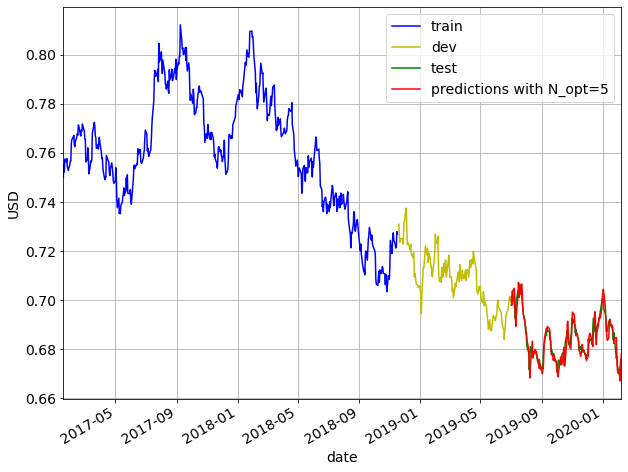

In [16]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(y='USD', style='b-', grid=True)
ax = cv.plot(y='USD', style='y-', grid=True, ax=ax)
ax = test.plot(y='USD', style='g-', grid=True, ax=ax)
ax = test.plot(y='est_N4', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=5'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

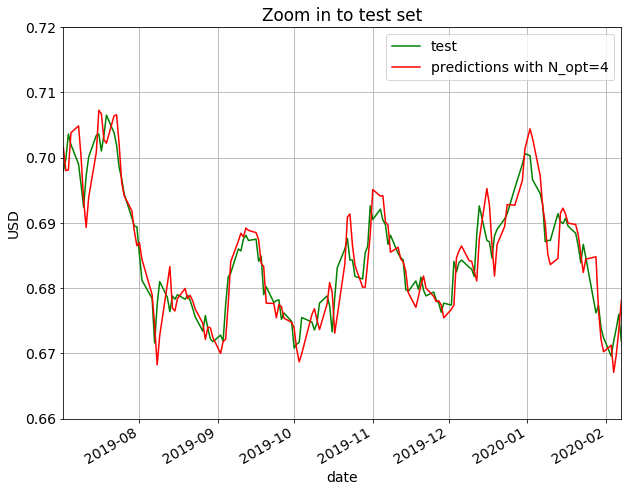

In [17]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

# ax = train.plot(y='USD', style='b', grid=True)
# ax = cv.plot(y='USD', style='y', grid=True)
ax = test.plot(y='USD', style='g', grid=True)
ax = test.plot(y='est_N4', style='r', grid=True, ax=ax)
ax.legend(['test', 'predictions with N_opt=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 7, 2), date(2020, 2, 7)])
ax.set_ylim([0.66, 0.72])
ax.set_title('Zoom in to test set')

## Predictions using Linear Regression

(0.66, 0.72)

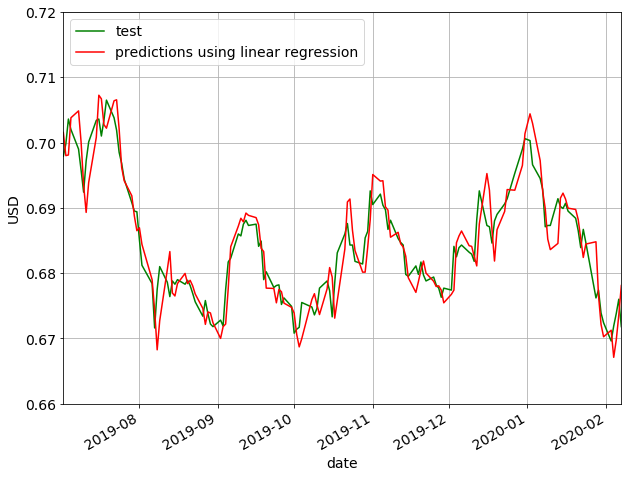

In [18]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(y='USD', style='g', grid=True)
ax = test.plot( y='est_N4', style='r', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(2019, 7, 2), date(2020, 2, 7)])
ax.set_ylim([0.66, 0.72])

## Obtaining Residuals from Test data and our Predictions

**1. Residual Plot**

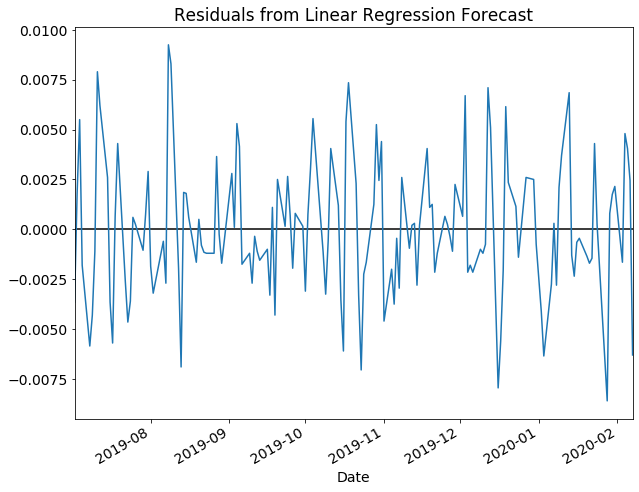

In [19]:
y_pred = test['est_N4']
y = test['USD']

residuals = y - y_pred
residuals.plot(title='Residuals from Linear Regression Forecast')
plt.hlines(0,'2018','2021')
plt.show()

**2. Histogram plus Estimated Density**

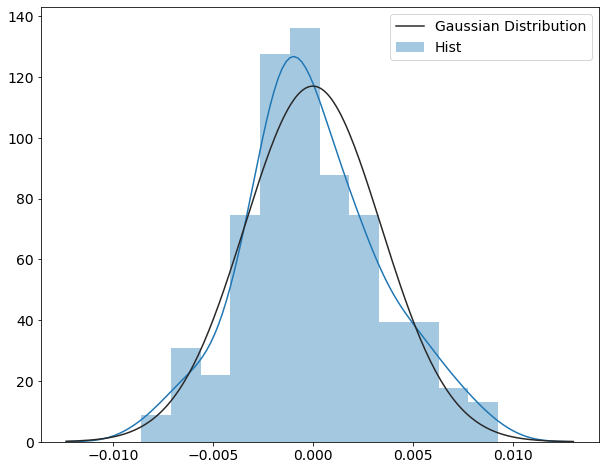

In [20]:
from scipy.stats import norm
sns.distplot(residuals, fit=norm)
plt.legend(['Gaussian Distribution', 'Hist'])

**3. Normal Q-Q Plot**

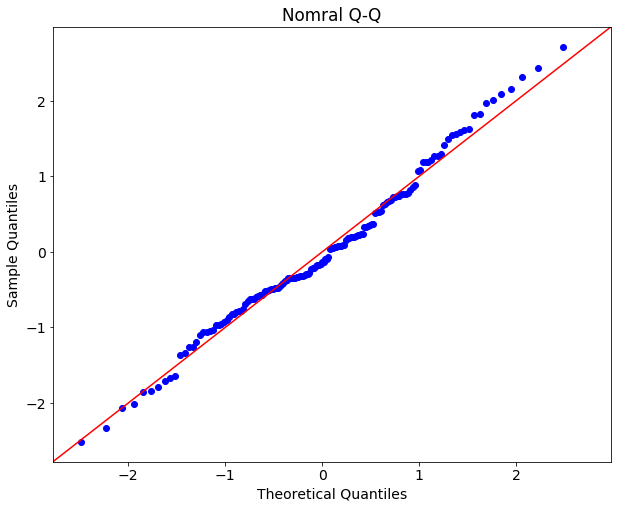

In [21]:
from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

resid = pd.DataFrame(zip(y, y_pred))
qqplot(residuals, fit=True, line='45')
plt.title('Nomral Q-Q')
plt.show()

**4. Correlation among Residuals (Correlogram)**

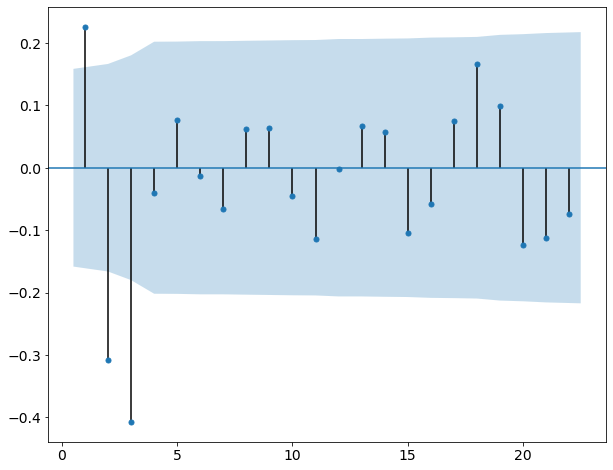

In [22]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, zero=False)
plt.title("")
plt.show()

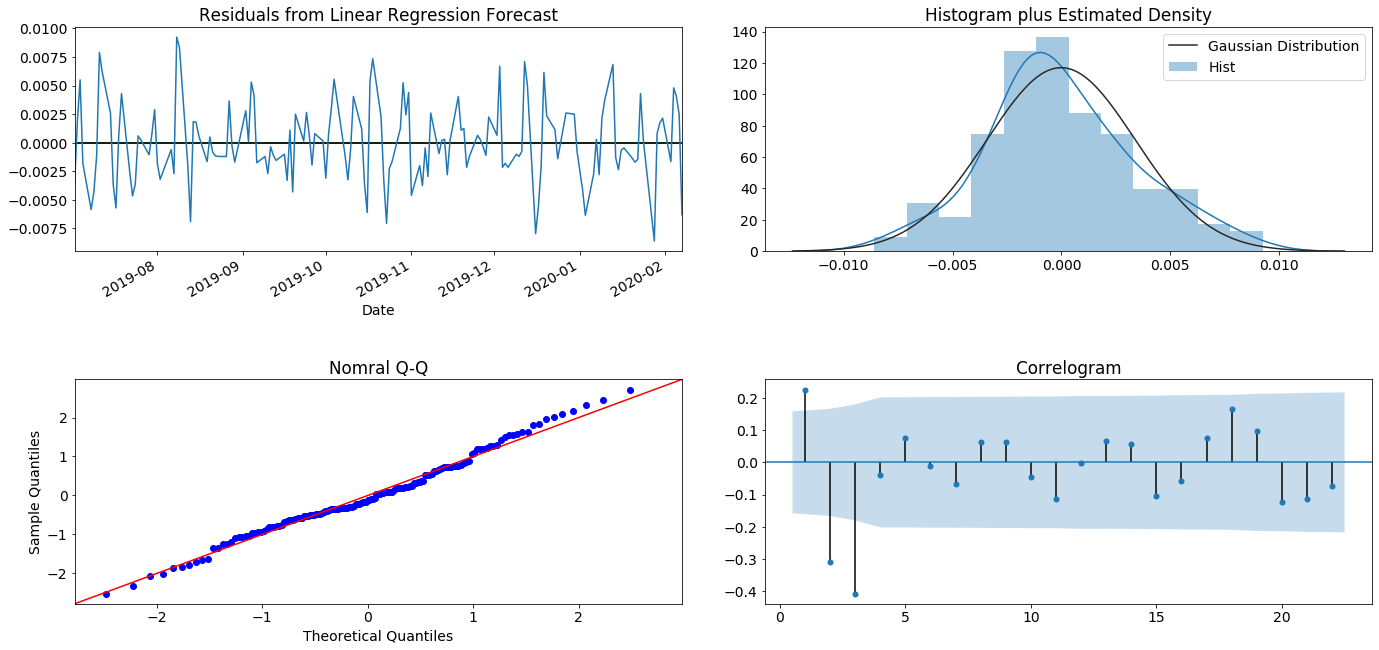

In [23]:
def residual_diagnostics(y, y_pred, model_name=""):
    from scipy.stats import norm
    from statsmodels.graphics.gofplots import qqplot
    from statsmodels.graphics.tsaplots import plot_acf

    residuals = y - y_pred

    fig, ax = plt.subplots(2,2, figsize=(20,10))

    # Residual Plot
    residuals.plot(title='Residuals from {}Forecast'.format(model_name+" "), ax=ax[0,0])
    resid_mean = residuals.mean()
    ax[0,0].hlines(resid_mean, '2018','2021', color='green')
    ax[0,0].hlines(0,'2018','2021', color='black', label='Residual Mean')

    # Histogram-KDE plot
    sns.distplot(residuals, fit=norm, ax=ax[0,1])
    ax[0,1].legend(['Gaussian Distribution', 'Hist'])
    ax[0,1].set_title('Histogram plus Estimated Density')


    # Normal Q-Q Plot
    resid = pd.DataFrame(zip(y, y_pred))
    qqplot(residuals, fit=True, line='45', ax=ax[1,0])
    ax[1,0].set_title('Nomral Q-Q')
    # plt.show()

    # Correlogram
    plot_acf(residuals, zero=False, ax=ax[1,1])
    ax[1,1].set_title("Correlogram")

    fig.tight_layout(pad=3)

    fig.show()
    
    return residuals
    
residuals = residual_diagnostics(y, y_pred, "Linear Regression")

In [24]:
import statsmodels.api as sm

test_stat, p_val = sm.stats.acorr_ljungbox(residuals, lags=[20])
print("P-Value =", p_val)
print("Ljung-Box Statistic =", test_stat)

P-Value = [2.61681845e-07]
Ljung-Box Statistic = [69.03396426]


In [25]:
buy_sell_df = pd.DataFrame(zip(y, y_pred), columns=['USD', 'Predictions'])

buy_sell_df['predicted_change'] = buy_sell_df['Predictions'].diff().shift(-1)

buy_sell_df['buy'] = buy_sell_df['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

buy_sell_df

,USD,Predictions,predicted_change,buy
0,0.6979,0.70155,-0.00355,0
1,0.6998,0.69800,0.00010,1
2,0.7036,0.69810,0.00570,1
3,0.7020,0.70380,0.00105,1
4,0.6990,0.70485,-0.00475,0
...,...,...,...,...
148,0.6696,0.67125,-0.00415,0
149,0.6719,0.66710,0.00265,1
150,0.6738,0.66975,0.00380,1
151,0.6760,0.67355,0.00455,1


Profit from predictions = -0.82


,USD,Predictions,predicted_change,buy
Date,,,,
2019-07-02,0.6979,0.70155,-0.00355,0
2019-07-03,0.6998,0.69800,0.00010,1
2019-07-04,0.7036,0.69810,0.00570,1
2019-07-05,0.7020,0.70380,0.00105,1
2019-07-08,0.6990,0.70485,-0.00475,0
...,...,...,...,...
2020-02-03,0.6696,0.67125,-0.00415,0
2020-02-04,0.6719,0.66710,0.00265,1
2020-02-05,0.6738,0.66975,0.00380,1


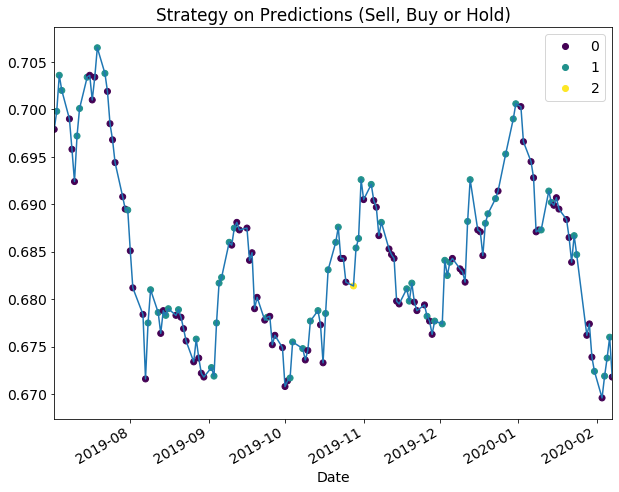

In [26]:
def buy_usd(aud_amt, exchange_rate):
    return aud_amt * exchange_rate

def buy_aud(usd_amt, exchange_rate):
    return usd_amt / exchange_rate

def backtest_simulation(buy_sell_df, init_balance=100, n=1):
    
    profits = []
    
    for iterations in range(n):
        # 1 - Buy USD
        # 0 - Sell USD
        # 2 - Hold
        
        strategy = buy_sell_df.buy

        init_aud_wallet = init_balance
        usd_wallet = 0
        aud_wallet = init_balance
        
        for i in range(len(strategy)):

                exchange_rate = buy_sell_df.iloc[i].values[0]

                if strategy[i] == 1:                    
                    new_usd = buy_usd(0.4 * aud_wallet, exchange_rate)
                    aud_wallet -= 0.4 * aud_wallet
                    usd_wallet += new_usd
                elif strategy[i] == 0:
                    new_aud = buy_aud(usd_wallet, exchange_rate)
                    usd_wallet = 0
                    aud_wallet += new_aud
                else:
                    continue
                    
        final_money_aud = aud_wallet + buy_aud(usd_wallet, exchange_rate)
        
        profit = final_money_aud - init_aud_wallet
        
        profits.append(profit)
    
    profits = np.array(profits)
    median_simulation_profit = np.median(profits)
    
    return profits

def backtest(y, y_pred):
    buy_sell_df = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    buy_sell_df['predicted_change'] = buy_sell_df['Predictions'].diff().shift(-1)
    buy_sell_df['buy'] = buy_sell_df['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

    buy_sell_df['USD'].plot()
    scatter = plt.scatter(buy_sell_df.index, buy_sell_df['USD'], c=buy_sell_df.buy)
    legend = plt.legend(*scatter.legend_elements())
    plt.title("Strategy on Predictions (Sell, Buy or Hold)")
    
    profit = backtest_simulation(buy_sell_df)
    
    print("Profit from predictions = %.2f"%profit[0])
    return buy_sell_df
    
bsdf = backtest(y, y_pred)
bsdf

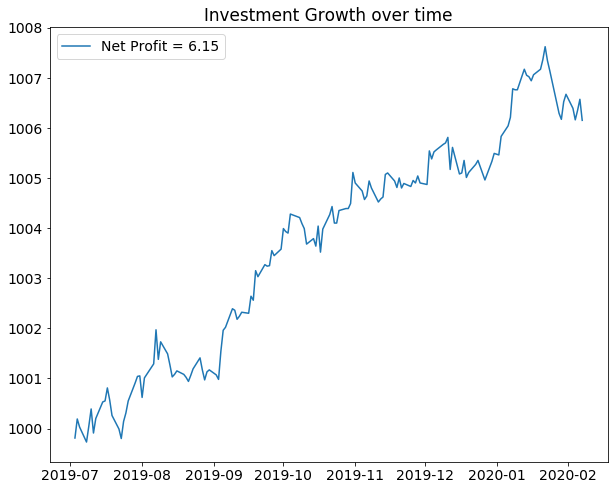

In [27]:
def backtest(y, y_pred, initial_investment=1000, trade_amount=100):

    bsdf = pd.DataFrame(zip(y, y_pred), index = y.index, columns=['USD', 'Predictions'])
    
    bsdf['predicted_change'] = bsdf['Predictions'].diff().shift(-1)
    bsdf['buy'] = bsdf['predicted_change'].apply(lambda x: 1 if x >0 else (2 if x==0 else 0))

    logs = []
    profits = []

    strategy = bsdf.buy
    wallet = initial_investment

    for i in range(len(strategy)-1):
        rate_today = y[i]
        rate_future = y[i+1]
        buy = strategy[i]
#         print(buy)

        trade_money = trade_amount * rate_today
        wallet -= trade_amount

        if buy == 0:
            profit = trade_money - trade_amount * rate_future
        elif buy == 1:
            profit = trade_amount * rate_future - trade_money
        elif buy == 2:
            profit = 0
       
        
        if profit >= 0:
            wallet += trade_amount + profit
        else:
            wallet += trade_amount + profit

        logs.append(wallet)

    net_profit = wallet - initial_investment
    
    plt.plot(bsdf.index[1:], logs)
    plt.legend(["Net Profit = %.2f"%(net_profit)])
    plt.title("Investment Growth over time")
    plt.show()

    return net_profit, logs

model_net_profit, investment_growth = backtest(y, y_pred)

In [28]:
initial_investment = 1000
trade_amount = 100

profits = []

for it in range(1000):

    random_strategy = np.random.randint(2, size=len(y))

    wallet = initial_investment
    logs = []

    for i in range(len(random_strategy)-1):
        rate_today = y[i]
        rate_future = y[i+1]
        buy = random_strategy[i]
    #         print(buy)

        trade_money = trade_amount * rate_today
        wallet -= trade_amount

        if buy == 0:
            profit = trade_money - trade_amount * rate_future
        elif buy == 1:
            profit = trade_amount * rate_future - trade_money
        elif buy == 2:
            profit = 0


        if profit >= 0:
            wallet += trade_amount + profit
        else:
            wallet += trade_amount + profit

        logs.append(wallet)

    net_profit = wallet - initial_investment
    
    profits.append(net_profit)

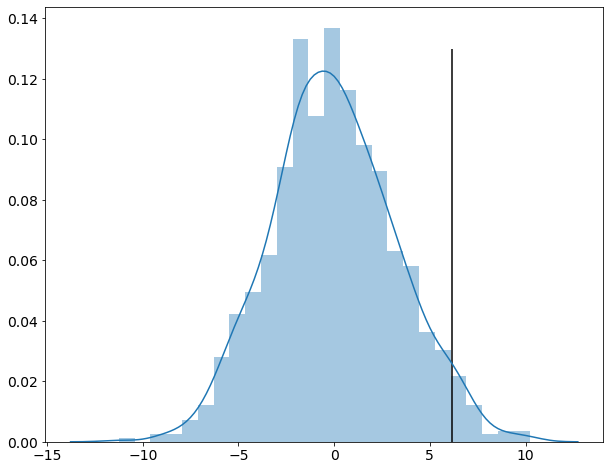

In [29]:
sns.distplot(profits)
plt.vlines(model_net_profit, 0, 0.13)